In this notebook we explain how do we implement the Displaced Diffusion model, here are the steps

1. Retrieve market implied volatility
2. Find sigma and beta so that volatility difference is minimized
3. Use sigma and beta from #2 to calculate dd pricing
4. Retrieve impl vol for dd pricing results
5. Plot implied vols for market and DD

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from scipy.optimize import least_squares
import matplotlib.ticker as ticker

import sys

sys.path.append("..")

from analytical_option_formulae.option_types.vanilla_option import VanillaOption

vanilla_option = VanillaOption()

# please adjust this before running, its either SPX or SPY

In [2]:
# implied volatility reporting


def implied_volatility(
    S: float, K: float, r: float, price: float, T: float, options_type: str
) -> float:
    try:
        bs_model = lambda x: vanilla_option.black_scholes_model(S, K, r, x, T)
        if options_type.lower() == "call":
            implied_vol = brentq(
                lambda x: price - bs_model(x).calculate_call_price(), 1e-12, 10.0
            )
        elif options_type.lower() == "put":
            implied_vol = brentq(
                lambda x: price - bs_model(x).calculate_put_price(), 1e-12, 10.0
            )
        else:
            raise NameError("Payoff type not recognized")
    except Exception:
        implied_vol = np.nan

    return implied_vol

In [3]:
def dd_calibration(x, S, strikes, rate, sigma, T, market_vols, option_type):
    err = 0.0
    imp_vol_list = []
    for i, strike in enumerate(strikes):
        dd_model = vanilla_option.displaced_diffusion_model(
            S, strike, rate, sigma, T, x[0]
        )
        # if True:
        if option_type[i] == "call":
            price = dd_model.calculate_call_price()
        else:
            price = dd_model.calculate_put_price()
        imp_vol = implied_volatility(S, strike, rate, price, T, option_type[i])
        imp_vol_list.append(imp_vol)

    zipped_vols = list(zip(market_vols, imp_vol_list))
    for market_vol, dd_vol in zipped_vols:
        err += (market_vol - dd_vol) ** 2

    return err

In [4]:
# SPX
filename = "SPX_options"
df = pd.read_csv(f"{filename}.csv")
df["mid"] = 0.5 * (df["best_bid"] + df["best_offer"])
df["strike"] = df["strike_price"] * 0.001
df["payoff"] = df["cp_flag"].map(lambda x: "call" if x == "C" else "put")
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["exdate"] = pd.to_datetime(df["exdate"], format="%Y%m%d")
df["days_to_expiry"] = (df["exdate"] - df["date"]).dt.days
df["years_to_expiry"] = df["days_to_expiry"] / 365
# setup rates calculator



rates_df = pd.read_csv("zero_rates_20201201.csv")
rate_interpolate = interp1d(rates_df["days"], rates_df["rate"])
df["rates"] = (
    rate_interpolate(df["days_to_expiry"]) / 100.0
)  # make it in fractions so i dont forget



try:
    if filename.lower() == "spy_options":

        S = 366.02
    elif filename.lower() == "spx_options":

        S = 3662.45
    else:
        raise NameError("unknown input file")
except Exception as e:
    print(e)



# impl market volatility column


df["vols"] = df.apply(
    lambda x: implied_volatility(
        S, x["strike"], x["rates"], x["mid"], x["years_to_expiry"], x["payoff"]
    ),
    axis=1,
)
df.dropna(inplace=True)

In [5]:
# create market DF for each timestamp
days_to_expiry = sorted(df["days_to_expiry"].unique())
summary_df = pd.DataFrame({"strike": df["strike"].unique()})
option_type = []
for days in days_to_expiry:
    day_df = df[df["days_to_expiry"] == days]
    call_df = day_df[day_df["payoff"] == "call"]
    put_df = day_df[day_df["payoff"] == "put"]
    strikes = sorted(day_df["strike"].unique())
    impliedvols = []
    for K in strikes:
        if K > S:
            impliedvols.append(call_df[call_df["strike"] == K]["vols"].values[0])
            option_type.append("call")
        else:
            impliedvols.append(put_df[put_df["strike"] == K]["vols"].values[0])
            option_type.append("put")

    day_market_df = pd.DataFrame({"strike": strikes, days: impliedvols})
    summary_df = pd.merge(summary_df, day_market_df, how="outer", on="strike")

summary_df["option_type"] = summary_df.apply(
    lambda x: "call" if x["strike"] > S else "put", axis=1
)
summary_df = summary_df.sort_values(by=["strike"])
summary_df = summary_df.reset_index()
summary_df = summary_df.drop(columns=["index"])

In [6]:
# get atm implied vols, this is an approximation but good enough
atm_vols = []
for i, days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0, 1 + i, -1]].copy()
    adjusted_summary_df.dropna(inplace=True)
    atm_vols.append(
        np.interp(S, adjusted_summary_df.iloc[:, 0], adjusted_summary_df.iloc[:, 1])
    )

In [7]:
sigma_beta_pair = {}
for i, days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0, 1 + i, -1]].copy()
    adjusted_summary_df.dropna(inplace=True)

    # params
    sigma = atm_vols[i]
    rate = rate_interpolate(days) / 100.0
    T = days / 365.0
    F = S * np.exp(rate * T)
    print(f"{S} {F} {sigma} {rate} {T}")

    strikes = adjusted_summary_df.iloc[:, 0].to_numpy()
    market_vols = adjusted_summary_df.iloc[:, 1].to_numpy()
    option_type = adjusted_summary_df.iloc[:, -1].to_numpy()
    initial = [0.5]
    result = least_squares(
        dd_calibration,
        initial,
        args=(S, strikes, rate, sigma, T, market_vols, option_type),
        bounds=(0.0, 1.0),
    )
    beta = result.x[0]
    sigma_beta_pair[days] = {"sigma": sigma, "beta": beta}

366.02 366.0413953221589 0.200905534391913 0.0012550044444444445 0.04657534246575343
366.02 366.11256803322914 0.1972176434869465 0.0020510755555555554 0.1232876712328767


KeyboardInterrupt: 

In [ ]:
dd_summary_df = pd.DataFrame({"strike": df["strike"].unique()})
for i, days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0, 1 + i, -1]].copy()
    adjusted_summary_df.dropna(inplace=True)
    sigma = sigma_beta_pair[days]["sigma"]
    beta = sigma_beta_pair[days]["beta"]
    rate = rate_interpolate(days) / 100.0
    T = days / 365.0

    strikes = adjusted_summary_df.iloc[:, 0].to_numpy()
    market_vols = adjusted_summary_df.iloc[:, 1].to_numpy()
    option_type = adjusted_summary_df.iloc[:, -1].to_numpy()

    dd_price = []
    dd_impl_vol = []

    for i, strike in enumerate(strikes):
        new_dd_model = vanilla_option.displaced_diffusion_model(
            S, strike, rate, sigma, T, beta
        )
        if option_type[i] == "call":
            price = new_dd_model.calculate_call_price()
        else:
            price = new_dd_model.calculate_put_price()
        imp_vol = implied_volatility(S, strike, rate, price, T, option_type[i])
        dd_price.append(price)
        dd_impl_vol.append(imp_vol)

    day_dd_imp_df = pd.DataFrame({"strike": strikes, days: dd_impl_vol})
    dd_summary_df = pd.merge(dd_summary_df, day_dd_imp_df, how="outer", on="strike")
    dd_summary_df = dd_summary_df.sort_values(by=["strike"])
    dd_summary_df = dd_summary_df.reset_index()
    dd_summary_df = dd_summary_df.drop(columns=["index"])
    dd_summary_df.to_csv(f"{filename}_DD_vol_summary.csv")

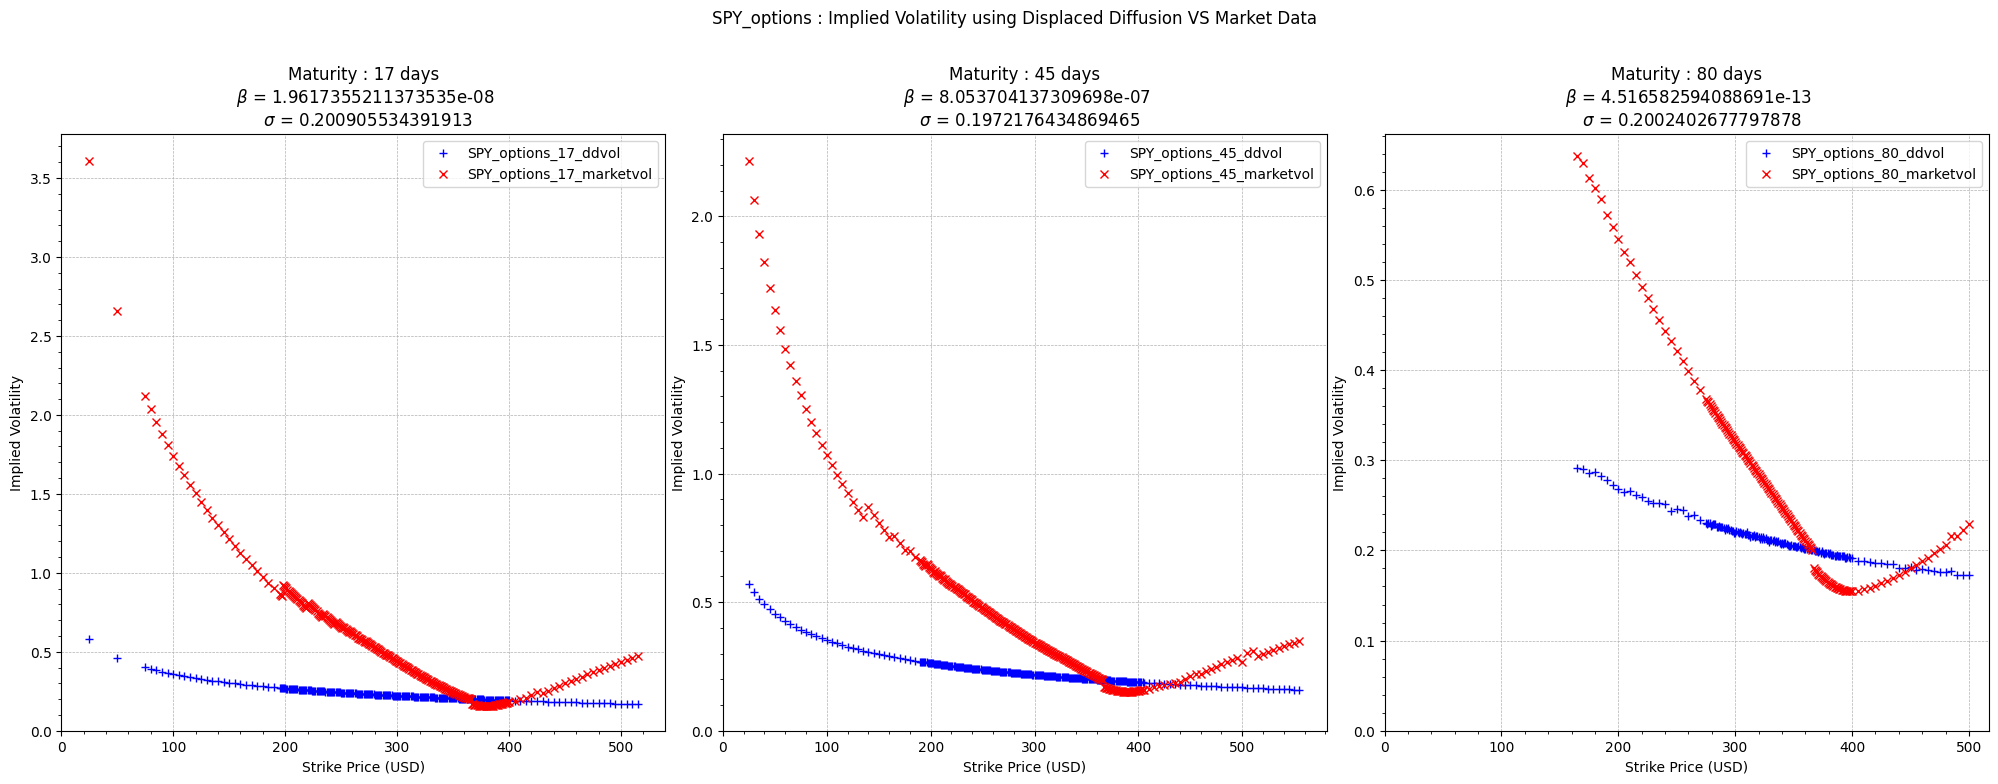

In [ ]:
# pd.set_option('display.max_rows', 500)
beta_text = r"$\beta$"
sigma_text = r"$\sigma$"
f1, ax1 = plt.subplots(1, 3)
f1.set_figheight(8)
f1.set_figwidth(20)
f1.tight_layout(rect=[0, 0.03, 1, 0.85])
for i, days in enumerate(days_to_expiry):
    sigma = sigma_beta_pair[days]["sigma"]
    beta = sigma_beta_pair[days]["beta"]
    ax1[i].plot(
        summary_df["strike"],
        dd_summary_df.iloc[:, 1 + i],
        "+",
        color="blue",
        label=f"{filename}_{days}_ddvol",
    )
    ax1[i].plot(
        summary_df["strike"],
        summary_df.iloc[:, 1 + i],
        "x",
        color="red",
        label=f"{filename}_{days}_marketvol",
    )
    ax1[i].legend()
    ax1[i].xaxis.set_major_locator(ticker.AutoLocator())
    ax1[i].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1[i].yaxis.set_major_locator(ticker.AutoLocator())
    ax1[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1[i].grid(linestyle="--", linewidth=0.5)
    ax1[i].set_ylim(ymin=0)
    ax1[i].set_xlim(xmin=0)
    ax1[i].set_xlabel("Strike Price (USD)")
    ax1[i].set_ylabel("Implied Volatility")
    ax1[i].set_title(
        f"Maturity : {days} days\n {beta_text} = {beta} \n  {sigma_text} = {sigma}"
    )
f1.suptitle(f"{filename} : Implied Volatility using Displaced Diffusion VS Market Data")
plt.show(f1)
f1.savefig(f"{filename}_dd_vol_summary.jpeg")

In [ ]:
# SPY
filename = "SPY_options"
df = pd.read_csv(f"{filename}.csv")
df["mid"] = 0.5 * (df["best_bid"] + df["best_offer"])
df["strike"] = df["strike_price"] * 0.001
df["payoff"] = df["cp_flag"].map(lambda x: "call" if x == "C" else "put")
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["exdate"] = pd.to_datetime(df["exdate"], format="%Y%m%d")
df["days_to_expiry"] = (df["exdate"] - df["date"]).dt.days
df["years_to_expiry"] = df["days_to_expiry"] / 365
# setup rates calculator


rates_df = pd.read_csv("zero_rates_20201201.csv")
rate_interpolate = interp1d(rates_df["days"], rates_df["rate"])
df["rates"] = (
    rate_interpolate(df["days_to_expiry"]) / 100.0
)  # make it in fractions so i dont forget


try:
    if filename.lower() == "spy_options":
        S = 366.02
    elif filename.lower() == "spx_options":
        S = 3662.45
    else:
        raise NameError("unknown input file")
except Exception as e:
    print(e)


# impl market volatility column


df["vols"] = df.apply(
    lambda x: implied_volatility(
        S, x["strike"], x["rates"], x["mid"], x["years_to_expiry"], x["payoff"]
    ),
    axis=1,
)
df.dropna(inplace=True)

In [ ]:
# create market DF for each timestamp
days_to_expiry = sorted(df["days_to_expiry"].unique())
summary_df = pd.DataFrame({"strike": df["strike"].unique()})
option_type = []
for days in days_to_expiry:
    day_df = df[df["days_to_expiry"] == days]
    call_df = day_df[day_df["payoff"] == "call"]
    put_df = day_df[day_df["payoff"] == "put"]
    strikes = sorted(day_df["strike"].unique())
    impliedvols = []
    for K in strikes:
        if K > S:
            impliedvols.append(call_df[call_df["strike"] == K]["vols"].values[0])
            option_type.append("call")
        else:
            impliedvols.append(put_df[put_df["strike"] == K]["vols"].values[0])
            option_type.append("put")

    day_market_df = pd.DataFrame({"strike": strikes, days: impliedvols})
    summary_df = pd.merge(summary_df, day_market_df, how="outer", on="strike")

summary_df["option_type"] = summary_df.apply(
    lambda x: "call" if x["strike"] > S else "put", axis=1
)
summary_df = summary_df.sort_values(by=["strike"])
summary_df = summary_df.reset_index()
summary_df = summary_df.drop(columns=["index"])

In [ ]:
# get atm implied vols, this is an approximation but good enough
atm_vols = []
for i, days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0, 1 + i, -1]].copy()
    adjusted_summary_df.dropna(inplace=True)
    atm_vols.append(
        np.interp(S, adjusted_summary_df.iloc[:, 0], adjusted_summary_df.iloc[:, 1])
    )

In [ ]:
sigma_beta_pair = {}
for i, days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0, 1 + i, -1]].copy()
    adjusted_summary_df.dropna(inplace=True)

    # params
    sigma = atm_vols[i]
    rate = rate_interpolate(days) / 100.0
    T = days / 365.0
    F = S * np.exp(rate * T)
    print(f"{S} {F} {sigma} {rate} {T}")

    strikes = adjusted_summary_df.iloc[:, 0].to_numpy()
    market_vols = adjusted_summary_df.iloc[:, 1].to_numpy()
    option_type = adjusted_summary_df.iloc[:, -1].to_numpy()
    initial = [0.5]
    result = least_squares(
        dd_calibration,
        initial,
        args=(S, strikes, rate, sigma, T, market_vols, option_type),
        bounds=(0.0, 1.0),
    )
    beta = result.x[0]
    sigma_beta_pair[days] = {"sigma": sigma, "beta": beta}

In [ ]:
dd_summary_df = pd.DataFrame({"strike": df["strike"].unique()})
for i, days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0, 1 + i, -1]].copy()
    adjusted_summary_df.dropna(inplace=True)
    sigma = sigma_beta_pair[days]["sigma"]
    beta = sigma_beta_pair[days]["beta"]
    rate = rate_interpolate(days) / 100.0
    T = days / 365.0

    strikes = adjusted_summary_df.iloc[:, 0].to_numpy()
    market_vols = adjusted_summary_df.iloc[:, 1].to_numpy()
    option_type = adjusted_summary_df.iloc[:, -1].to_numpy()

    dd_price = []
    dd_impl_vol = []

    for i, strike in enumerate(strikes):
        new_dd_model = vanilla_option.displaced_diffusion_model(
            S, strike, rate, sigma, T, beta
        )
        if option_type[i] == "call":
            price = new_dd_model.calculate_call_price()
        else:
            price = new_dd_model.calculate_put_price()
        imp_vol = implied_volatility(S, strike, rate, price, T, option_type[i])
        dd_price.append(price)
        dd_impl_vol.append(imp_vol)

    day_dd_imp_df = pd.DataFrame({"strike": strikes, days: dd_impl_vol})
    dd_summary_df = pd.merge(dd_summary_df, day_dd_imp_df, how="outer", on="strike")
    dd_summary_df = dd_summary_df.sort_values(by=["strike"])
    dd_summary_df = dd_summary_df.reset_index()
    dd_summary_df = dd_summary_df.drop(columns=["index"])
    dd_summary_df.to_csv(f"{filename}_DD_vol_summary.csv")

In [ ]:
# pd.set_option('display.max_rows', 500)
beta_text = r"$\beta$"
sigma_text = r"$\sigma$"
f1, ax1 = plt.subplots(1, 3)
f1.set_figheight(8)
f1.set_figwidth(20)
f1.tight_layout(rect=[0, 0.03, 1, 0.85])
for i, days in enumerate(days_to_expiry):
    sigma = sigma_beta_pair[days]["sigma"]
    beta = sigma_beta_pair[days]["beta"]
    ax1[i].plot(
        summary_df["strike"],
        dd_summary_df.iloc[:, 1 + i],
        "+",
        color="blue",
        label=f"{filename}_{days}_ddvol",
    )
    ax1[i].plot(
        summary_df["strike"],
        summary_df.iloc[:, 1 + i],
        "x",
        color="red",
        label=f"{filename}_{days}_marketvol",
    )
    ax1[i].legend()
    ax1[i].xaxis.set_major_locator(ticker.AutoLocator())
    ax1[i].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1[i].yaxis.set_major_locator(ticker.AutoLocator())
    ax1[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1[i].grid(linestyle="--", linewidth=0.5)
    ax1[i].set_ylim(ymin=0)
    ax1[i].set_xlim(xmin=0)
    ax1[i].set_xlabel("Strike Price (USD)")
    ax1[i].set_ylabel("Implied Volatility")
    ax1[i].set_title(
        f"Maturity : {days} days\n {beta_text} = {beta} \n  {sigma_text} = {sigma}"
    )
f1.suptitle(f"{filename} : Implied Volatility using Displaced Diffusion VS Market Data")
plt.show(f1)
f1.savefig(f"{filename}_dd_vol_summary.jpeg")